# Instability of arbitrary order finite difference stencils

This notebook implemented arbitrary-order finite differences and demonstrates that discrete high-order Taylor expansions become inaccurate. 

/tmp/ipykernel_31632/3247373926.py:138: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


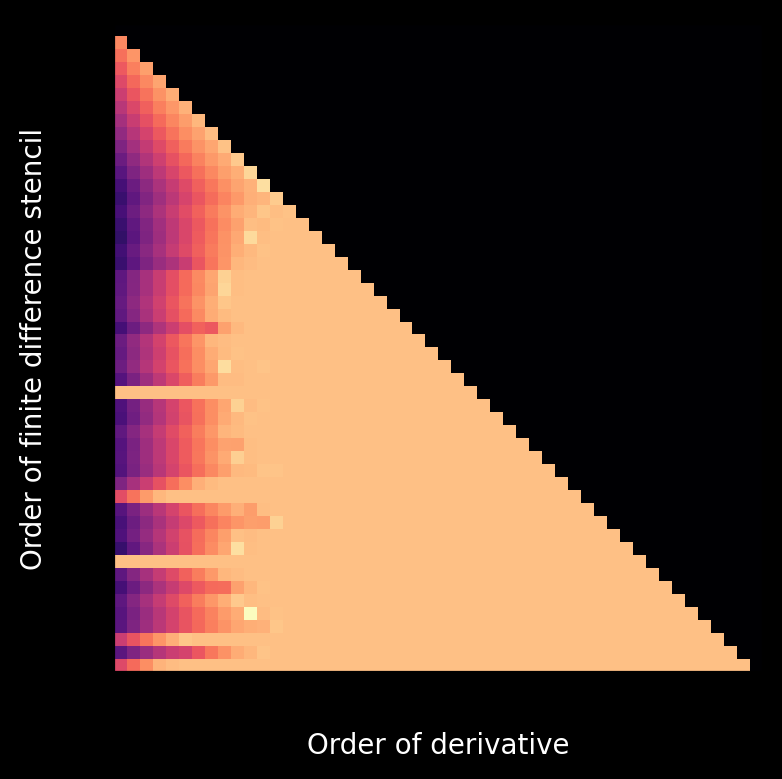

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

def forward_difference_matrix(order, dx):
    """
    Create a forward difference matrix of a given order and spacing.

    Args:
        order (int): The order of the matrix.
        dx (float): The spacing between points.

    Returns:
        numpy.ndarray: The forward difference matrix.
    """
    size = order
    mat = np.zeros((size, size))
    for k in range(1, size + 1):
        for j in range(1, size + 1):
            mat[j - 1, k - 1] = (j * dx) ** k / np.math.factorial(k)

    return mat

def backward_difference_matrix(order, dx):
    """
    Create a backward difference matrix of a given order and spacing.

    Args:
        order (int): The order of the matrix.
        dx (float): The spacing between points.

    Returns:
        numpy.ndarray: The backward difference matrix.
    """
    size = order
    mat = np.zeros((size, size))
    for k in range(1, size + 1):
        for j in range(1, size + 1):
            mat[j - 1, k - 1] = (-j * dx) ** k / np.math.factorial(k)

    return mat

def forward_difference_vector(order, f):
    """
    Create a forward difference vector for a given function and order.

    Args:
        order (int): The order of the difference.
        f (numpy.ndarray): The function values.

    Returns:
        numpy.ndarray: The forward difference vector.
    """
    diff = np.zeros(order)
    for j in range(1, order + 1):
        diff[j - 1] = f[j] - f[0]
    return diff

def backward_difference_vector(order, f):
    """
    Create a backward difference vector for a given function and order.

    Args:
        order (int): The order of the difference.
        f (numpy.ndarray): The function values.

    Returns:
        numpy.ndarray: The backward difference vector.
    """
    diff = np.zeros(order)
    for j in range(1, order + 1):
        diff[j - 1] = f[-1 - j] - f[-1]
    return diff

def iterative_refinement(A, b, tolerance=1e-12):
    """
    Solve a system of linear equations Ax = b using iterative refinement.

    Args:
        A (numpy.ndarray): The matrix A.
        b (numpy.ndarray): The vector b.
        tolerance (float): The tolerance for the residual error.

    Returns:
        numpy.ndarray: The solution vector x.
    """
    x = np.linalg.solve(A, b)
    residual = b - A @ x
    residual_error = np.sum(np.abs(residual))

    iteration = 0
    while residual_error > tolerance:
        correction = np.linalg.solve(A, residual)
        x += correction
        residual = b - A @ x
        residual_error = np.sum(np.abs(residual))
        iteration += 1
        if iteration > 10:
            break

    return x


x = np.linspace(0, 10, 64)

def func(x, derivative_order=0):
    return np.exp(x)

f = func(x)

N = 50
errors            = np.zeros((N, N))

for fd_order in np.arange(N) :
    dx = x[1] - x[0]
    A = forward_difference_matrix (fd_order + 1, dx)
    b = forward_difference_vector (fd_order + 1, f)
    Dl = iterative_refinement(A, b)
    A = backward_difference_matrix (fd_order + 1, dx)
    b = backward_difference_vector (fd_order + 1,  f)
    Dr = iterative_refinement(A, b)

    for derivative_order in range(fd_order):
        error = np.abs(func(x[0], derivative_order + 1) - Dl[derivative_order])/(np.abs(Dl[derivative_order])+1e-8)
        errors[fd_order, derivative_order]  = error

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
plt.imshow(np.log10(errors + 1e-15), cmap="magma")
plt.ylabel("Order of finite difference stencil")
plt.xlabel("Order of derivative")
plt.gcf().set_facecolor("k")
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')


fig.tight_layout()
fig.savefig("figures/fd_instability.png", bbox_inches='tight')
fig.show()


Darker shades of purple represent lower errors in the above plot. For finite difference stencils up to roughly $12$ order, the errors for lower-order derivatives decrease and high-order derivatives become accessible. For finite difference stencils with order $> 12$, even the the estimation of low-order derivatives fails and it is impossible to accurately estimate derivatives with order $> 12$. Note that the upper right triangle is black since we can only estimate a derivative of order $N$ with a finite difference stencil of at least order $N$ .